The very first attampt to use QuantLib and BS model and generate a call price.
stock_price is stored in quote so we can change the value later.

In [1]:
import QuantLib as ql
import numpy as np
from timeit import default_timer as timer


# option data
maturity_date = ql.Date(30, 10, 2020)
stock_price = ql.SimpleQuote(170.0)
strike_price = 150
volatility = ql.SimpleQuote(0.10) # the historical vols for a year
dividend_rate =  ql.SimpleQuote(0.002)
risk_free_rate = ql.SimpleQuote(0.003)
option_type = ql.Option.Call

day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(27, 10, 2019)
ql.Settings.instance().evaluationDate = calculation_date

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

spot_handle = ql.QuoteHandle(stock_price)
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, ql.QuoteHandle(risk_free_rate), day_count))
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, ql.QuoteHandle(dividend_rate), day_count))
flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, ql.QuoteHandle(volatility), day_count))
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)


Analytic Black-Scholes calculation:

In [2]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
time_bs_start = timer()
bs_price = european_option.NPV()
delta = european_option.delta()
gamma = european_option.gamma() #second order
vega = european_option.vega()
rho = european_option.rho()
theta = european_option.theta()
time_bs_end = timer()
time_bs = time_bs_end - time_bs_start


print("The theoretical price is ", bs_price)
print("The delta is ", delta)#Change in underlying price
print("The gamma is ", gamma)#second order: rate of change in price
print("The vega is ", vega)#Change in volatility
print("The rho is ", rho)#Change in interest rate
print("The theta is ", theta)#Change in time to expiration
print("Time used for BS calculation in total is ", time_bs)


The theoretical price is  20.912114216635807
The delta is  0.9022541582733737
The gamma is  0.009938484700038275
The vega is  29.03698484648708
The rho is  133.9228306919182
The theta is  -1.5267579034120837
Time used for BS calculation in total is  0.00037180500001454675


In [6]:
#prepare for plotting
xs_bs = np.linspace(100, 200, 400)
ys_bs = []
for x in xs_bs:
    stock_price.setValue(x)
    ys_bs.append(european_option.NPV())

Instead of using analytic Black-Scholes formula, we can use Monte-Carlo simulation, output the price and the Greeks.

In [3]:
stock_price.setValue(170)
engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                                      timeSteps=20,
                                      requiredSamples=250000)
european_option.setPricingEngine(engine)

time_mc_start = timer()
bs_price = european_option.NPV()
error = european_option.errorEstimate()
print("The monte carlo theoretical price is ", bs_price)
print("The monte carlo error is ", error)

#The Greeks for Monte-Carlo
p_original = bs_price
original_price = stock_price.value()
change_stock_price = 0.1
stock_price.setValue(original_price + change_stock_price)
p_plus = european_option.NPV()
print('price plus: ', p_plus)
stock_price.setValue(original_price - change_stock_price)
p_minus = european_option.NPV()
print('price minus: ', p_minus)
stock_price.setValue(original_price)
mc_delta = (p_plus - p_minus) / (2*change_stock_price)
mc_gamma = (p_plus - 2*original_price + p_minus) /(change_stock_price*change_stock_price)
print("delta in MC is: ", mc_delta)
print("gamma in MC is: ", mc_gamma)

change_r = 0.001
original_r = risk_free_rate.value()
risk_free_rate.setValue(original_r + change_r)
p_plus = european_option.NPV()
risk_free_rate.setValue(original_r)
mc_rho = (p_plus - p_original) / change_r
print("rho in MC is: ", mc_rho)

change_sigma = 0.001
original_sigma = volatility.value()
volatility.setValue(original_sigma + change_sigma)
p_plus = european_option.NPV()
volatility.setValue(original_sigma)
mc_vega = (p_plus - p_original) / change_sigma
print("vega in MC is: ", mc_vega)

ql.Settings.instance().evaluationDate = calculation_date + 1
p_later = european_option.NPV()
change_in_time = 1.0 / 365
mc_thema = (p_later - p_original) / change_in_time
print("thema in MC is: ", mc_thema)

time_mc_end = timer()
time_mc = time_mc_end - time_mc_start

print("Time used for MC calculation in total is ", time_mc, ' seconds')


The monte carlo theoretical price is  20.918709017560285
The monte carlo error is  0.03159308810880852
price plus:  21.011396313260615
price minus:  20.82025094570825
delta in MC is:  0.95572683776183
gamma in MC is:  -29816.83527410311
rho in MC is:  127.60613107322172
vega in MC is:  16.645633691137363
thema in MC is:  13.934418035493188
Time used for MC calculation in total is  9.033005421000013


NameError: name 'xs_bs' is not defined

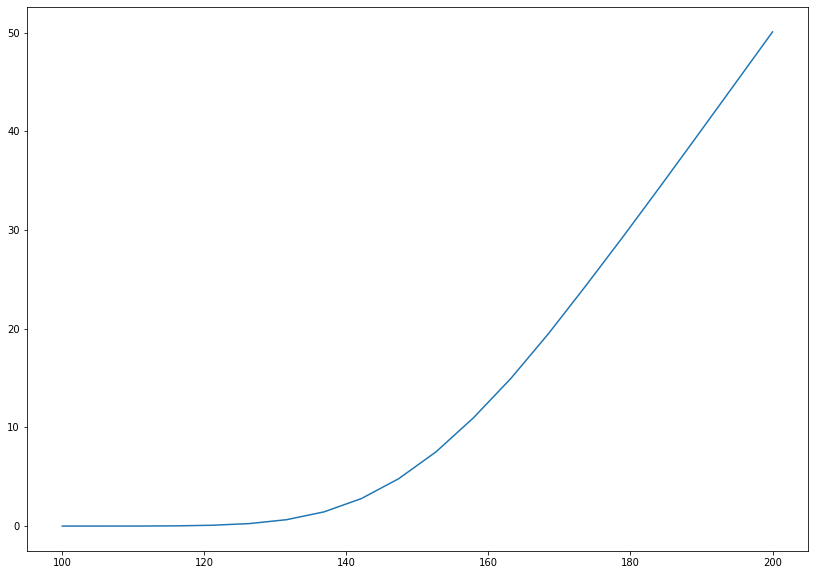

In [93]:
%matplotlib inline
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

xs = np.linspace(100, 200, 20)
ys = []
for x in xs:
    stock_price.setValue(x)
    ys.append(european_option.NPV())
    
plt.figure(figsize=(14,10))
plt.plot(xs, ys)
plt.plot(xs_bs, ys_bs, linestyle='dashed')
plt.xlabel('stock price') 
plt.ylabel('call price') 
plt.title('Option Price') 
plt.show() 

An Option Class which stores all the options info; return BS model call price; return the wanted data set for training purpose.

In [4]:
class Option:
    def __init__(self, calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type):
        self.maturity = maturity
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.dividend_rate = dividend_rate
        self.risk_free_rate = risk_free_rate
        self.option_type = option_type
        self.calculation_date = calculation_date
        self.bs_price = -1
        
    def BSM_price(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.risk_free_rate, day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, self.dividend_rate, day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, self.volatility, day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
        bs_price = european_option.NPV()
        self.bs_price = bs_price
        return self.bs_price
    
    def data_set(self):
        '''
        Funtion to return a set of required data for one sample for training purpose.
        
        '''
        if self.bs_price == -1:
            self.BSM_price()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        data_set = (self.stock_price, self.strike_price, maturity_in_year, self.dividend_rate, self.volatility, self.risk_free_rate, self.bs_price)
        return data_set


Functions to help in converting and auto-generate specific numbers of options sample data for training.

In [5]:
import datetime
import random
import pandas as pd

'''Date helper functions'''
def xldate_to_datetime(xldate):
    temp = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

def datetime_to_xldate(date):
    temp = datetime.datetime(1899, 12, 30)
    return (date - temp).days

def random_options(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,10,30)
    end_maturity = datetime.datetime(2022,10,30)

    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0.001, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option.BSM_price())
    return options

def random_options_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Call
        option = Option(calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type)
        options.append(option.data_set())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
    return dataframe


Generate Sample Data for DL

In [6]:
n = 100000
df = random_options_pd(n)
## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K
df['stock_price'] = df['stock_price']/df['strike_price']
df['call_price'] = df['call_price']/df['strike_price']
#print(df)
#print(df.isnull().any())
n_train =  (int)(0.8 * n)
train = df[0:n_train]
X_train = train[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_train = train['call_price'].values
test = df[n_train+1:n]
X_test = test[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_test = test['call_price'].values


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
from tensorflow import squeeze

# problem is not because of my custom activation function, it's because of exponential activation not applied in this case.

nodes = 65
model = Sequential()

model.add(Dense(nodes, input_dim=X_train.shape[1]))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes, activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('linear'))
          
model.compile(loss='mse',optimizer='rmsprop', metrics=['mse'])

model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1, verbose=2)
score, acc = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(acc))


Train on 72000 samples, validate on 8000 samples
Epoch 1/10
 - 3s - loss: 15.3861 - val_loss: 0.2749
Epoch 2/10
 - 2s - loss: 1.0573 - val_loss: 0.9147
Epoch 3/10
 - 2s - loss: 0.8504 - val_loss: 1.0916
Epoch 4/10
 - 2s - loss: 0.7454 - val_loss: 0.8482
Epoch 5/10
 - 2s - loss: 0.6616 - val_loss: 0.4341
Epoch 6/10
 - 2s - loss: 0.6224 - val_loss: 0.7866
Epoch 7/10
 - 2s - loss: 0.6042 - val_loss: 1.2171
Epoch 8/10
 - 2s - loss: 0.5872 - val_loss: 0.5141
Epoch 9/10
 - 2s - loss: 0.5906 - val_loss: 0.4689
Epoch 10/10
 - 2s - loss: 0.5590 - val_loss: 0.3655
The mean squared error (MSE) for the test data set is: 0.4005015614104021


A modified NN which gives really good results. Haven't adapted to their scaling method.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import keras

model = Sequential()
model.add(Dense(50,input_dim=6,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)
]

model.fit(X_train, y_train, epochs=30, validation_split=0.2,callbacks=callbacks,
        shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

y_train_hat = model.predict(X_train)

y_test_hat = model.predict(X_test)


Train on 64000 samples, validate on 16000 samples
Epoch 1/30
 - 4s - loss: 0.5455 - val_loss: 0.0139
Epoch 2/30
 - 3s - loss: 0.0424 - val_loss: 0.0335
Epoch 3/30
 - 3s - loss: 0.0410 - val_loss: 0.0182
Epoch 00003: early stopping
The mean squared error (MSE) for the test data set is: 0.018813118167073272


In [56]:
options = []
greek_option = Option(calculation_date, maturity_date, 168, 150, 0.002, 0.1, 0.003, option_type)
greeks_data = greek_option.data_set()
options.append(greeks_data)
df = pd.DataFrame(options)
df.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
df['stock_price'] = df['stock_price']/df['strike_price']
df['call_price'] = df['call_price']/df['strike_price']
greek_input = df[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
print("greek-input data taken is: ", greek_input)
nn_original_price = model.predict(greek_input) 
print('original price: ', df['call_price'].values, ' predicted price: ', nn_original_price)

'''
test_data = [X_test[100]]
result = y_test[100]
xa = np.array(test_data)
print("testing data taken is: ", test_data, " with result price as: ", result)
nn_original_price = model.predict(greek_input) 
print(nn_original_price)
'''


greek-input data taken is:  [[1.12000000e+00 1.50000000e+02 1.01369863e+00 1.00000000e-01
  2.00000000e-03 3.00000000e-03]]
original price:  [0.01506709]  predicted price:  [[0.20021424]]


'\ntest_data = [X_test[100]]\nresult = y_test[100]\nxa = np.array(test_data)\nprint("testing data taken is: ", test_data, " with result price as: ", result)\nnn_original_price = model.predict(greek_input) \nprint(nn_original_price)\n'

In [63]:
df = random_options_pd(1)

df['stock_price'] = df['stock_price']/df['strike_price']
df['call_price'] = df['call_price']/df['strike_price']
greek_input = df[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
print("greek-input data taken is: ", greek_input)
nn_original_price = model.predict(greek_input)[0][0] 
print('original price: ', df['call_price'].values, ' predicted price: ', nn_original_price)

time_mc_start = timer()

#The Greeks for DL model
#why it's forever negative, problem is my saving variables for Python!!

change_stock_price = 0.1
original_price = nn_original_price

df['stock_price'] = (df['stock_price']*df['strike_price'] + change_stock_price)/df['strike_price']
greek_input = df[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
print('value for plus: ', greek_input)
p_plus = model.predict(greek_input)[0][0] 
print('price plus: ', p_plus)

df['stock_price'] = (df['stock_price']*df['strike_price'] - 2*change_stock_price)/df['strike_price']
greek_input = df[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
print('value for plus: ', greek_input)
p_minus = model.predict(greek_input)[0][0] 
print('price minus: ', p_minus)
df['stock_price'] = (df['stock_price']*df['strike_price'] + change_stock_price)/df['strike_price']

dl_delta = (p_plus - p_minus) / (2*change_stock_price)
dl_gamma = (p_plus - 2*original_price + p_minus) /(change_stock_price*change_stock_price)

print("delta in MC is: ", dl_delta)
print("gamma in MC is: ", dl_gamma)

change_r = 0.001
df['risk_free_rate'] = df['risk_free_rate'] + change_r
greek_input = df[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
print('value for rho: ', greek_input)
p_plus = model.predict(greek_input)[0][0] 
print('price plus: ', p_plus)
df['risk_free_rate'] = df['risk_free_rate'] - change_r
dl_rho = (p_plus - original_price) / change_r
print("rho in MC is: ", dl_rho)

change_sigma = 0.001
df['volatility'] = df['volatility'] + change_sigma
greek_input = df[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
print('value for vega: ', greek_input)
p_plus = model.predict(greek_input)[0][0] 
print('price plus: ', p_plus)
df['volatility'] = df['volatility'] - change_sigma
dl_vega = (p_plus - original_price) / change_sigma
print("vega in MC is: ", dl_vega)

change_in_time = 1.0 / 365
df['maturity'] = df['maturity'] + change_in_time
greek_input = df[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
print('value for thema: ', greek_input)
p_later = model.predict(greek_input)[0][0] 
dl_thema = (p_later - original_price) / change_in_time
print("thema in MC is: ", dl_thema)

time_mc_end = timer()
time_mc = time_mc_end - time_mc_start

print("Time used for MC calculation in total is ", time_mc, ' seconds')


greek-input data taken is:  [[6.55647383e-01 3.63000000e+02 8.63013699e-01 1.71563560e-03
  7.61498346e-01 2.51856748e-03]]
original price:  [0.09391341]  predicted price:  0.11021515
value for plus:  [[6.55922865e-01 3.63000000e+02 8.63013699e-01 1.71563560e-03
  7.61498346e-01 2.51856748e-03]]
price plus:  0.11031356
value for plus:  [[6.55371901e-01 3.63000000e+02 8.63013699e-01 1.71563560e-03
  7.61498346e-01 2.51856748e-03]]
price minus:  0.11012336
delta in MC is:  0.0009509921073913574
gamma in MC is:  0.0006616115570068358
value for rho:  [[6.55647383e-01 3.63000000e+02 8.63013699e-01 1.71563560e-03
  7.61498346e-01 3.51856748e-03]]
price plus:  0.11017724
rho in MC is:  -0.03790855407714844
value for vega:  [[6.55647383e-01 3.63000000e+02 8.63013699e-01 1.71563560e-03
  7.62498346e-01 2.51856748e-03]]
price plus:  0.11037751
vega in MC is:  0.16236305236816406
value for thema:  [[6.55647383e-01 3.63000000e+02 8.65753425e-01 1.71563560e-03
  7.61498346e-01 2.51856748e-03]]
them

Hyperparameter Optimization with Tree-structured Parzen Estimators (TPE) method

In [85]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend
import keras

model = Sequential()
model.add(Dense(64,input_dim=6,activation='relu'))
model.add(Dropout(0.003331930415424511))

model.add(Dense(126,activation='relu'))
model.add(Dropout(0.2931001552138646))

model.add(Dense(64,activation='elu'))
model.add(Dropout(0.25100000541347456))

model.add(Dense(126,activation='elu'))
model.add(Dropout(0.2738488340941711))

model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='rmsprop', metrics=['mse'])

#no. of epochs as a hyperparameter

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=2, shuffle=True)
test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))


Train on 64000 samples, validate on 16000 samples
Epoch 1/10
 - 3s - loss: 6.5926 - mse: 6.5926 - val_loss: 0.2802 - val_mse: 0.2802
Epoch 2/10
 - 2s - loss: 1.0300 - mse: 1.0300 - val_loss: 0.3550 - val_mse: 0.3550
Epoch 3/10
 - 2s - loss: 0.8483 - mse: 0.8483 - val_loss: 0.3648 - val_mse: 0.3648
Epoch 4/10
 - 2s - loss: 0.7176 - mse: 0.7176 - val_loss: 0.3942 - val_mse: 0.3942
Epoch 5/10
 - 2s - loss: 0.6558 - mse: 0.6558 - val_loss: 0.2790 - val_mse: 0.2790
Epoch 6/10
 - 3s - loss: 0.5824 - mse: 0.5824 - val_loss: 0.3749 - val_mse: 0.3749
Epoch 7/10
 - 3s - loss: 0.5490 - mse: 0.5490 - val_loss: 0.4835 - val_mse: 0.4835
Epoch 8/10
 - 3s - loss: 0.5442 - mse: 0.5442 - val_loss: 0.3689 - val_mse: 0.3689
Epoch 9/10
 - 3s - loss: 0.4530 - mse: 0.4530 - val_loss: 0.1357 - val_mse: 0.1357
Epoch 10/10
 - 3s - loss: 0.4983 - mse: 0.4983 - val_loss: 0.1946 - val_mse: 0.1946
The mean squared error (MSE) for the test data set is: [0.1823417966520567, 0.1823417842388153]


In [99]:
options = []
greek_option = Option(calculation_date, maturity_date, 170, 150, 0.002, 0.1, 0.003, option_type)
greeks_data = greek_option.data_set()
print(greeks_data)
options.append(greeks_data)
df = pd.DataFrame(options)
df.columns = ['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'call_price']
df['stock_price'] = df['stock_price']/df['strike_price']
df['call_price'] = df['call_price']/df['strike_price']
print(df)
greek_input = df[['stock_price', 'strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
xa = np.array(greek_input)

nn_original_price = model.predict(xa) 
print(nn_original_price)

#TODO: pick one point from the test data set, maybe this point is an outliner;


(170, 150, 1.010958904109589, 0.1, 0.002, 0.003, 4.108123278533351)
   stock_price  strike_price  maturity  devidends  volatility  risk_free_rate  \
0     1.133333           150  1.010959        0.1       0.002           0.003   

   call_price  
0    0.027387  
[[0.28387246]]


In [22]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.python.client import device_lib
import tensorflow as tf

print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7434966614734429415
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9210949796
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5980424637199658622
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Num GPUs Available:  1


['/job:localhost/replica:0/task:0/device:GPU:0']

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LeakyReLU
from keras import backend

model = Sequential()

nodes = 100
model.add(Dense(nodes,input_dim=6))
model.add(LeakyReLU())
model.add(Dropout(0.25))

model.add(Dense(nodes,activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(nodes,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(nodes,activation='elu'))
model.add(Dropout(0.25))

model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

model.fit(X_train, y_train, epochs=10, shuffle=True, verbose=2)

test_error_rate = model.evaluate(X_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

y_train_hat = model.predict(X_train)
print(y_train_hat)

y_test_hat = model.predict(X_test)
print(y_test_hat)

Epoch 1/10
 - 9s - loss: 4.2128
Epoch 2/10
 - 8s - loss: 0.7495
Epoch 3/10
 - 8s - loss: 0.6419
Epoch 4/10
 - 8s - loss: 0.6306
Epoch 5/10
 - 8s - loss: 0.5909
Epoch 6/10
 - 8s - loss: 0.5717
Epoch 7/10
 - 8s - loss: 0.5533
Epoch 8/10
 - 9s - loss: 0.5617
Epoch 9/10
 - 9s - loss: 0.5645
Epoch 10/10
 - 9s - loss: 0.5484
The mean squared error (MSE) for the test data set is: 0.3346826271476617
[[0.21677184]
 [0.21677184]
 [0.21677184]
 ...
 [0.38034475]
 [0.21677184]
 [0.21677184]]
[[10.313256  ]
 [ 0.21677184]
 [ 0.51833975]
 ...
 [ 1.5997694 ]
 [10.955016  ]
 [ 0.21677184]]


In [35]:
from statistics import *
from math import sqrt
import matplotlib as mpl
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats


In [28]:
#reduce dim (240000,1) -> (240000,) to match y_train's dim

y_train_hat = squeeze(y_train_hat).numpy()
CheckAccuracy(y_train, y_train_hat)

y_test_hat = squeeze(y_test_hat).numpy()
CheckAccuracy(y_test, y_test_hat)

NameError: name 'y_train_hat' is not defined

Load pre-trained model from hyper-parameter optimization scripts

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 256)               1792      
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_65 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_66 (Activation)   (None, 256)             

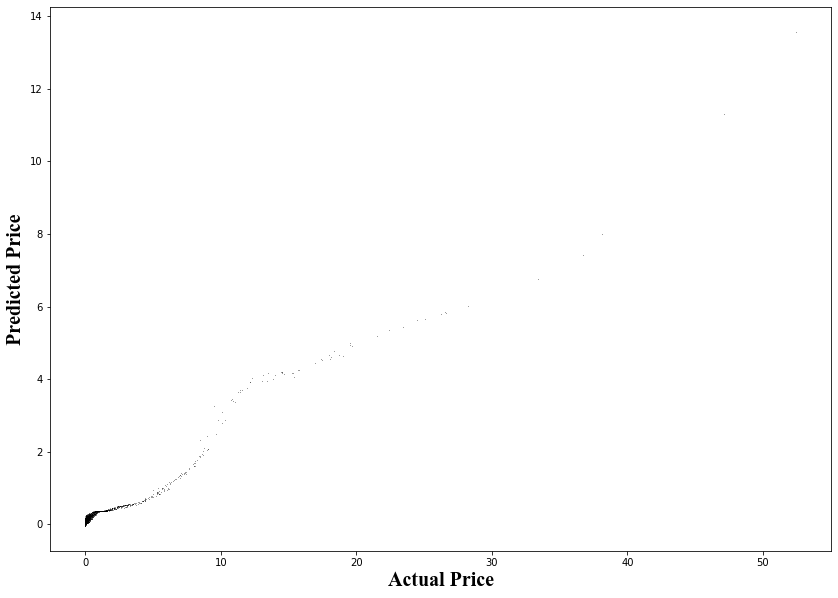

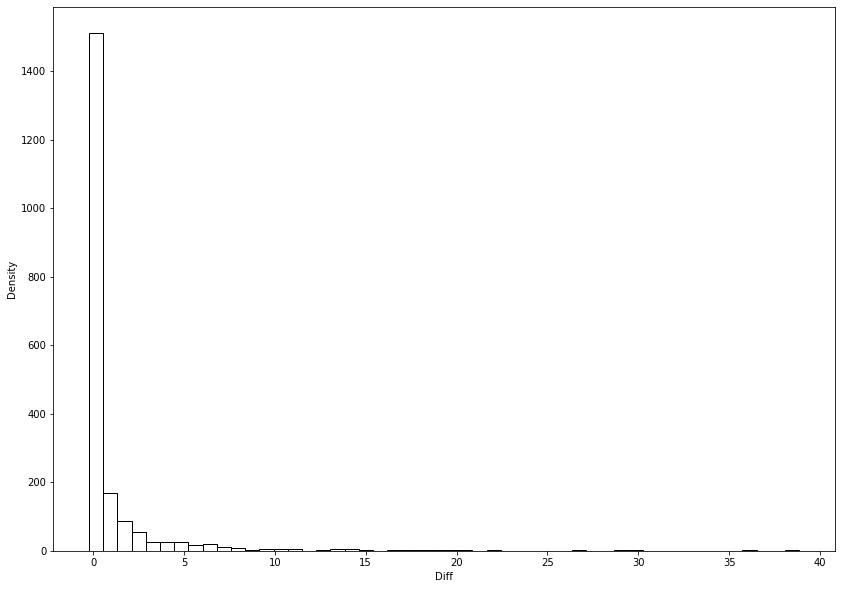

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

trained_model = Sequential()
trained_model.add(Dense(256,activation='relu', input_shape= (6,)))
trained_model.add(Dropout(0.1))
trained_model.add(Dense(256))
trained_model.add(Activation('relu'))
trained_model.add(Dropout(0.1))
trained_model.add(Dense(256))
trained_model.add(Activation('relu'))
trained_model.add(Dropout(0.1))
trained_model.add(Dense(256))
trained_model.add(Activation('relu'))
trained_model.add(Dropout(0.1))
trained_model.add(Dense(1))
trained_model.add(Activation('linear'))
trained_model.compile(loss='mean_squared_error', metrics=['mse'],
              optimizer='adam')
trained_model.load_weights('model_weights.h5')
trained_model.summary()

y_test_hat = trained_model.predict(X_test)

y_test_hat = np.squeeze(y_test_hat)
CheckAccuracy(y_test, y_test_hat)